In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
#from src.algorithms import *
#import torch
import sklearn
%load_ext autoreload
import scipy

In [2]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [5]:
filename = "20231129_ 952.h5"
#filename = "2023811_1451.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

In [6]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [7]:
lam = 1e2
p = 1e-1

pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [03:45<00:00,  1.88s/it]


In [56]:
pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        if sum_spec!=0:
            pro_data_norm[i,j,:]=spec/sum_spec
        else:
            pro_data_norm[i,j,:]=np.zeros(len(spec))

In [57]:
offset_l = 31
offset_m = 328

mask = pro_data_norm[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)

In [61]:
mask.shape

(9600, 297)

In [58]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

In [68]:
masks=mask.T
kmeans = sklearn.cluster.KMeans(n_clusters = 5)
a=kmeans.fit_predict(masks)

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


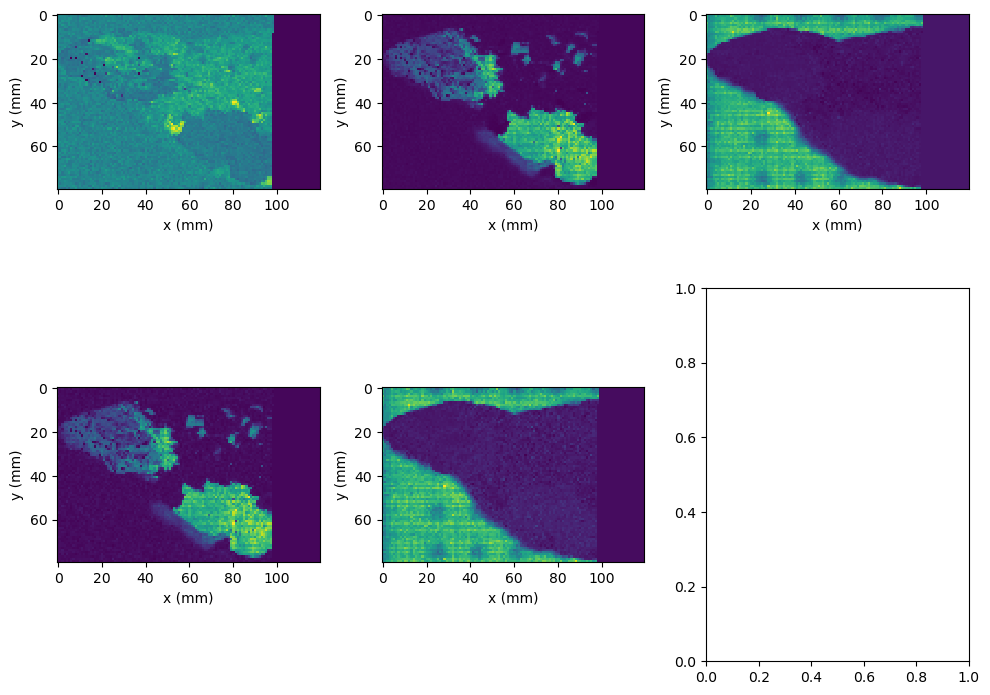

In [70]:
labels = kmeans.labels_

fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

## Cálculo da entropia

In [71]:
mask_min_max=scipy.ndimage.gaussian_filter(mask_min_max,sigma=0.5)

In [72]:
print(mask_min_max.shape)
entropy_masks=np.array([mask_min_max[i,:]*255 for i in range(297)])

(9600, 297)


In [73]:
def entropy_calc(map_gr):
    import cv2
    from scipy.stats import entropy

    #image

    _bins = 200

    hist, _ = np.histogram(map_gr, bins=_bins, range=(0, _bins))

    prob_dist = hist / hist.sum()
    image_entropy = entropy(prob_dist, base=2)
    return image_entropy